In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
from xgboost.sklearn import XGBClassifier
from xml.sax import ContentHandler, parse

stemmer = SnowballStemmer('english', ignore_stopwords=True)
stop = set(stopwords.words('english'))

%matplotlib inline
sns.set(rc={'figure.figsize':(15,11)})

In [59]:
plt.rcParams['figure.figsize'] = (15,11)

In [5]:
%%time

# Reference https://goo.gl/KaOBG3
class ExcelHandler(ContentHandler):
    def __init__(self):
        self.chars = [  ]
        self.cells = [  ]
        self.rows = [  ]
        self.tables = [  ]
    def characters(self, content):
        self.chars.append(content)
    def startElement(self, name, atts):
        if name=="Cell":
            self.chars = [  ]
        elif name=="Row":
            self.cells=[  ]
        elif name=="Table":
            self.rows = [  ]
    def endElement(self, name):
        if name=="Cell":
            self.cells.append(''.join(self.chars))
        elif name=="Row":
            self.rows.append(self.cells)
        elif name=="Table":
            self.tables.append(self.rows)

excelHandler = ExcelHandler()
parse('features.xls', excelHandler)
features = pd.DataFrame(excelHandler.tables[0][1:], columns=excelHandler.tables[0][0])
# objective = 0, subjective = 1
y = np.where(features['Label'] == 'objective', 0, 1)

texts = []
preprocessed_texts = []

for i in range(1, 1001):
    if i // 10 == 0:
        number = '000' + str(i)
    elif i // 100 == 0:
        number = '00' + str(i)
    elif i // 1000 == 0:
        number = '0' + str(i)
    else:
        number = '1000'
    
    f = open('Raw_data/Text' + number + '.txt', 'r', encoding='latin-1')
    text = f.read()
    preprocessed_text = ' '.join([stemmer.stem(w) for w in word_tokenize(text) if (w.isalpha() and w not in stop)])
    texts.append(text)
    preprocessed_texts.append(preprocessed_text)

data = pd.DataFrame({'texts': np.array(texts), 'preprocessed_texts': np.array(preprocessed_texts), 'label': y})
objective_texts = ' '.join(data[data['label'] == 0]['preprocessed_texts'].tolist())
subjective_texts = ' '.join(data[data['label'] == 1]['preprocessed_texts'].tolist())

Wall time: 21.6 s


In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.array(preprocessed_texts), y, random_state=13, stratify=y)

Creating TF-IDF matrices for train and test:

In [14]:
vectorizer = TfidfVectorizer(min_df=5, max_features=5000, ngram_range=(1, 1))
X_train_tfidf = vectorizer.fit_transform(X_train)

In [15]:
X_test_tfidf = vectorizer.transform(X_test)

Then we tried linear approach (Logistic Regression), metrics method (KNN), ensembling (Random Forest) and boosting (XGBoost) with several hyperparameters tuning.

# LR

In [28]:
%%time
kf = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
lr = LogisticRegression(random_state=13)
param_grid = {'penalty': ['l1','l2'], 'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 100, 1000]}
clf = GridSearchCV(estimator=lr, cv=kf, param_grid=param_grid, scoring='roc_auc')
clf.fit(X_train_tfidf, y_train)
print('Best score: {}'.format(clf.best_score_))
print('Best params: {}'.format(clf.best_params_))

Best score: 0.8156127621241657
Best params: {'C': 1, 'penalty': 'l2'}
Wall time: 3.7 s


In [31]:
lr = LogisticRegression(random_state=13, C=1, penalty='l2')
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=13, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
roc_auc_score(y_test, lr.predict_proba(X_test_tfidf)[:, 1])

0.8315709447784919

# KNN

In [45]:
%%time
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 202, 2)), 'weights': ['uniform', 'distance']}
clf = GridSearchCV(estimator=knn, cv=kf, param_grid=param_grid, scoring='roc_auc')
clf.fit(X_train_tfidf, y_train)
print('Best score: {}'.format(clf.best_score_))
print('Best params: {}'.format(clf.best_params_))

Best score: 0.8025671421820545
Best params: {'n_neighbors': 199, 'weights': 'distance'}
Wall time: 2min 9s


In [46]:
knn = KNeighborsClassifier(n_neighbors=199, weights='distance')
knn.fit(X_train_tfidf, y_train)
roc_auc_score(y_test, knn.predict_proba(X_test_tfidf)[:, 1])

0.8349574953348539

# RF

In [51]:
%%time
rf = RandomForestClassifier(random_state=13, verbose=1)
param_grid = {'n_estimators': [200, 500, 1000], 'max_features': ['auto', 'log2'], 'max_depth': [4, 5, 6, 7, 8],
              'criterion': ['gini', 'entropy']}
clf = GridSearchCV(estimator=rf, cv=kf, param_grid=param_grid, scoring='roc_auc', verbose=1)
clf.fit(X_train_tfidf, y_train)
print('Best score: {}'.format(clf.best_score_))
print('Best params: {}'.format(clf.best_params_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finishe

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.5s finished
[Parallel(n_jobs=1

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.2s finished


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]

Best score: 0.8343388047138047
Best params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 500}
Wall time: 12min 21s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished


In [53]:
rf = RandomForestClassifier(criterion='gini', max_depth=6, max_features='auto', n_estimators=500, random_state=13)
rf.fit(X_train_tfidf, y_train)
roc_auc_score(y_test, rf.predict_proba(X_test_tfidf)[:, 1])

0.8510608887967379

# XGB

In [65]:
xgb = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=1,
                     gamma=1, objective='binary:logistic', seed=13)
xgb.fit(X_train_tfidf, y_train)
roc_auc_score(y_test, xgb.predict_proba(X_test_tfidf)[:, 1])

0.8373419033796391

In [68]:
%%time
xgb = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=1,
                     gamma=1, objective='binary:logistic', seed=13, verbose=1)
param_grid = {'max_depth': [3, 4, 5, 6, 7, 8]}
clf = GridSearchCV(estimator=xgb, cv=kf, param_grid=param_grid, scoring='roc_auc', verbose=1)
clf.fit(X_train_tfidf, y_train)
print('Best score: {}'.format(clf.best_score_))
print('Best params: {}'.format(clf.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished


Best score: 0.8249057069230314
Best params: {'max_depth': 3}
Wall time: 2min 35s


In [69]:
%%time
xgb = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=1,
                     gamma=1, objective='binary:logistic', seed=13, verbose=2)
param_grid = {'learning_rate': [0.01, 0.03, 0.05, 0.075, 0.1]}
clf = GridSearchCV(estimator=xgb, cv=kf, param_grid=param_grid, scoring='roc_auc', verbose=1)
clf.fit(X_train_tfidf, y_train)
print('Best score: {}'.format(clf.best_score_))
print('Best params: {}'.format(clf.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.3min finished


Best score: 0.8450081900880146
Best params: {'learning_rate': 0.05}
Wall time: 1min 21s


In [71]:
xgb = XGBClassifier(learning_rate=0.05, n_estimators=100, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=1,
                     gamma=1, objective='binary:logistic', seed=13)
xgb.fit(X_train_tfidf, y_train)
roc_auc_score(y_test, xgb.predict_proba(X_test_tfidf)[:, 1])

0.850922662243417

In [72]:
%%time
xgb = XGBClassifier(learning_rate=0.05, n_estimators=100, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=1,
                     gamma=1, objective='binary:logistic', seed=13, verbose=2)
param_grid = {'subsample': [0.8, 0.9, 1.0]}
clf = GridSearchCV(estimator=xgb, cv=kf, param_grid=param_grid, scoring='roc_auc', verbose=1)
clf.fit(X_train_tfidf, y_train)
print('Best score: {}'.format(clf.best_score_))
print('Best params: {}'.format(clf.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   43.2s finished


Best score: 0.8450081900880146
Best params: {'subsample': 0.8}
Wall time: 46.9 s


In [73]:
%%time
xgb = XGBClassifier(learning_rate=0.05, n_estimators=100, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=1,
                     gamma=1, objective='binary:logistic', seed=13, verbose=2)
param_grid = {'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
clf = GridSearchCV(estimator=xgb, cv=kf, param_grid=param_grid, scoring='roc_auc', verbose=1)
clf.fit(X_train_tfidf, y_train)
print('Best score: {}'.format(clf.best_score_))
print('Best params: {}'.format(clf.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   51.4s finished


Best score: 0.8440717289857641
Best params: {'colsample_bytree': 0.6}
Wall time: 53.5 s


In [77]:
xgb = XGBClassifier(learning_rate=0.05, n_estimators=100, max_depth=3, min_child_weight=1, subsample=0.8, colsample_bytree=0.6,
                     gamma=1, objective='binary:logistic', seed=13)
xgb.fit(X_train_tfidf, y_train)
roc_auc_score(y_test, xgb.predict_proba(X_test_tfidf)[:, 1])

0.8621881263390698

# Results: ROC-curves

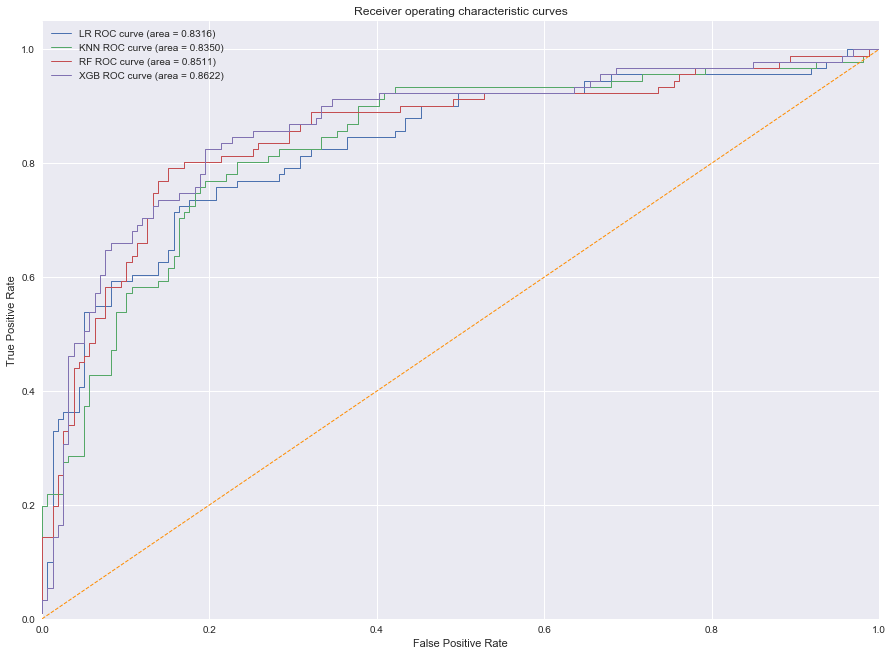

In [79]:
lr_prediction = lr.predict_proba(X_test_tfidf)
knn_prediction = knn.predict_proba(X_test_tfidf)
rf_prediction = rf.predict_proba(X_test_tfidf)
xgb_prediction = xgb.predict_proba(X_test_tfidf)

def generate_metrics(prediction):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, prediction[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc


lr_fpr, lr_tpr, lr_roc_auc = generate_metrics(lr_prediction)
knn_fpr, knn_tpr, knn_roc_auc = generate_metrics(knn_prediction)
rf_fpr, rf_tpr, rf_roc_auc = generate_metrics(rf_prediction)
xgb_fpr, xgb_tpr, xgb_roc_auc = generate_metrics(xgb_prediction)
plt.plot(lr_fpr[1], lr_tpr[1], lw=1, label='LR ROC curve (area = %0.4f)' % lr_roc_auc[1])
plt.plot(knn_fpr[1], knn_tpr[1], lw=1, label='KNN ROC curve (area = %0.4f)' % knn_roc_auc[1])
plt.plot(rf_fpr[1], rf_tpr[1], lw=1, label='RF ROC curve (area = %0.4f)' % rf_roc_auc[1])
plt.plot(xgb_fpr[1], xgb_tpr[1], lw=1, label='XGB ROC curve (area = %0.4f)' % xgb_roc_auc[1])
plt.plot([0, 1], [0, 1], lw=1, color='darkorange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves')
plt.legend(loc='best')
plt.show()